In [1]:
%%capture
!pip install tables
!pip install --upgrade --force-reinstall tensorflow
!pip install keras-tuner
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse
import scprep

def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(y_true.shape[0]):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, tf.shape(y_true)[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(tf.shape(y_true)[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

from sklearn.model_selection import train_test_split
import scprep

import math
import tensorflow as tf
import keras_tuner
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
LR_START = 0.01
BATCH_SIZE = 512

best_hp = keras_tuner.HyperParameters()
best_hp.values = {'reg1': 0.0001,
                'reg2': 3.307e-07,
                'units1': 1024,
                'units2': 1024,
                'units3': 1024,
                'lr': 0.001
                 }

LR_START = 0.01
BATCH_SIZE = 512

def create_model(input_shape, output_shape):
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(input_shape,))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(output_shape,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(output_shape, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    

    return model

2022-11-09 18:33:18.253791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 18:33:18.383881: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-09 18:33:18.421112: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 18:33:19.019810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [76]:
def evaluate(i,j,kind,save,loss=None):
    if (loss == None)&(kind=='multi'):
        loss = 'mse'
    elif (loss == None)&(kind=='cite'):
        loss = negative_correlation_loss
    assert(loss in ('mse',negative_correlation_loss))
    assert(kind in ('multi','cite'))
    VERBOSE = 0
    if loss:
        N_SPLIT = 6
    else:
        N_SPLIT = 3
    #kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    kf = KFold(n_splits = N_SPLIT)

    scores = []
    pca_scores = []
    Y_pred = np.zeros_like(Y)

    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        model = create_model(X.shape[1],Y.shape[1])

        lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

        es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 30, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

        if kind == 'cite':
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './cite',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
        else:
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './multi',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss = loss,
                      metrics = loss)
            
        model.fit(X_tr,
                  y_tr,
                  validation_data=(X_va,y_va),
                  epochs =500,
                  verbose = VERBOSE,
                  batch_size=256,
                  callbacks = [es,lr,chk]
                 )
        y_va_pred = model.predict(X_va)
        Y_pred[idx_va] = y_va_pred
        if kind == 'cite':
            corrscore = correlation_score(y_va, y_va_pred)
            scores.append(corrscore)
        else:
            corrscore = correlation_score(targets[idx_va], y_va_pred@svd.components_[:64])
            scores.append(corrscore)
            pca_corrscore = correlation_score(y_va[:,:64], y_va_pred[:,:64])
            pca_scores.append(pca_corrscore)

        if kind == 'cite':    
            model.fit(X_va,
                  y_va,
                  epochs=20,
                  verbose = VERBOSE,
                  batch_size=256
                 )    
            
        print(f'\n --------- FOLD {fold} -----------')
        if loss == 'mse':
            print(f'Mean squared error = {np.round(mean_squared_error(y_va,y_va_pred),2)}')
        print(f'Correlation = {corrscore:.5f}')
        if kind == 'multi':
            print(f'PCA Correlation = {pca_corrscore:.5f}')
        if kind == 'cite':
            filename = f"./cite_model_saves/model_{i}_{j}_{fold}"
        else:
            filename = f"./multi_model_saves/model_{i}_{j}_{fold}"
        if save:
            model.save(filename)
            print('model saved :',filename)

        del X_tr,X_va,y_tr,y_va
        gc.collect()

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(scores).mean():.5f}{Style.RESET_ALL}")
    if not loss:
        print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")

In [10]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [ ]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
for (i,j) in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[(i,j)]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[(i,j)]]
    evaluate(i,j,loss=False,save=False)

2022-11-09 18:21:56.173835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 18:21:56.180848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-09 18:21:56.180867: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-09 18:21:56.181257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

76/76 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.550000190734863
Correlation = 0.69108
PCA Correlation = 0.98142
76/76 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 6.610000133514404
Correlation = 0.68975
PCA Correlation = 0.98124
76/76 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 6.659999847412109
Correlation = 0.68806
PCA Correlation = 0.98100
Mean corr = 0.68963
Mean pca corr = 0.98122
100/100 [==============================] - 0s 1ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.090000152587891
Correlation = 0.67961
PCA Correlation = 0.98209
100/100 [==============================] - 0s 1ms/step

 --------- FOLD 1 -----------
Mean squared error = 6.019999980926514
Correlation = 0.67983
PCA Correlation = 0.98232
100/100 [==============================] - 0s 1ms/step

 --------- FOLD 2 -----------
Mean square

In [3]:
# constant_cols = list(X.columns[(X == 0).all(axis=0).values]) + list(X_test.columns[(X_test == 0).all(axis=0).values])
constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
print('Constant cols:', len(constant_cols))

important_cols = ['ENSG00000135218_CD36',
 'ENSG00000010278_CD9',
 'ENSG00000204287_HLA-DRA',
 'ENSG00000117091_CD48',
 'ENSG00000004468_CD38',
 'ENSG00000173762_CD7',
 'ENSG00000137101_CD72',
 'ENSG00000019582_CD74',
 'ENSG00000169442_CD52',
 'ENSG00000170458_CD14',
 'ENSG00000272398_CD24',
 'ENSG00000026508_CD44',
 'ENSG00000114013_CD86',
 'ENSG00000174059_CD34',
 'ENSG00000139193_CD27',
 'ENSG00000105383_CD33',
 'ENSG00000085117_CD82',
 'ENSG00000177455_CD19',
 'ENSG00000002586_CD99',
 'ENSG00000196126_HLA-DRB1',
 'ENSG00000135404_CD63',
 'ENSG00000012124_CD22',
 'ENSG00000134061_CD180',
 'ENSG00000105369_CD79A',
 'ENSG00000116824_CD2',
 'ENSG00000010610_CD4',
 'ENSG00000139187_KLRG1',
 'ENSG00000204592_HLA-E',
 'ENSG00000090470_PDCD7',
 'ENSG00000206531_CD200R1L',
'ENSG00000166710_B2M',
 'ENSG00000198034_RPS4X',
 'ENSG00000188404_SELL',
 'ENSG00000130303_BST2',
 'ENSG00000128040_SPINK2',
 'ENSG00000206503_HLA-A',
 'ENSG00000108107_RPL28',
 'ENSG00000143226_FCGR2A',
 'ENSG00000133112_TPT1',
 'ENSG00000166091_CMTM5',
 'ENSG00000026025_VIM',
 'ENSG00000205542_TMSB4X',
 'ENSG00000109099_PMP22',
 'ENSG00000145425_RPS3A',
 'ENSG00000172247_C1QTNF4',
 'ENSG00000072274_TFRC',
 'ENSG00000234745_HLA-B',
 'ENSG00000075340_ADD2',
 'ENSG00000119865_CNRIP1',
 'ENSG00000198938_MT-CO3',
 'ENSG00000135046_ANXA1',
 'ENSG00000235169_SMIM1',
 'ENSG00000101200_AVP',
 'ENSG00000167996_FTH1',
 'ENSG00000163565_IFI16',
 'ENSG00000117450_PRDX1',
 'ENSG00000124570_SERPINB6',
 'ENSG00000112077_RHAG',
 'ENSG00000051523_CYBA',
 'ENSG00000107130_NCS1',
 'ENSG00000055118_KCNH2',
 'ENSG00000029534_ANK1',
 'ENSG00000169567_HINT1',
 'ENSG00000142089_IFITM3',
 'ENSG00000139278_GLIPR1',
 'ENSG00000142227_EMP3',
 'ENSG00000076662_ICAM3',
 'ENSG00000143627_PKLR',
 'ENSG00000130755_GMFG',
 'ENSG00000160593_JAML',
 'ENSG00000095932_SMIM24',
 'ENSG00000197956_S100A6',
 'ENSG00000171476_HOPX',
 'ENSG00000116675_DNAJC6',
 'ENSG00000100448_CTSG',
 'ENSG00000100368_CSF2RB',
 'ENSG00000047648_ARHGAP6',
 'ENSG00000198918_RPL39',
 'ENSG00000196154_S100A4',
 'ENSG00000233968_AL157895.1',
 'ENSG00000137642_SORL1',
 'ENSG00000133816_MICAL2',
 'ENSG00000130208_APOC1',
 'ENSG00000105610_KLF1']
print('important columns ',len(important_cols))

Constant cols: 1194
important columns  84


In [4]:
DATA_DIR = "../input/open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

VERBOSE = 0

In [8]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [9]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [10]:
for (i,j) in selector.keys():
    Y = Y_copy.copy()
    X = X_copy.copy()
    Y = Y[selector[(i,j)]]
    X = X[selector[(i,j)]]
    evaluate(i,j,loss=True,save=False)

2022-11-09 18:34:13.494809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 18:34:13.502096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-09 18:34:13.502114: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-09 18:34:13.502465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.89586
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.89681
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.89779
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Correlation = 0.89723
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Correlation = 0.89967
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 5 -----------
Correlation = 0.89831
Mean corr = 0.89761
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.90494
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.90597
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.90707
32/32 [===================

KeyboardInterrupt: 

In [13]:
X_copy.shape

(70988, 159)

In [15]:
Y_copy.shape

(70988, 140)

In [84]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)

In [87]:
X = X.values

In [90]:
all_corrs = []
for j in range(140):
    my_corrs = []
    for i in range(X.shape[1]):
        my_corrs.append(np.corrcoef(X[:,i], Y_copy[:,j])[1, 0])
    my_corrs = list(pd.Series(my_corrs).apply(abs)\
                        .sort_values().iloc[-800:].index)
    all_corrs.append(my_corrs)
np.save('./corrs/cite_all_corrs.npy',all_corrs)

Text(0, 0.5, 'count')

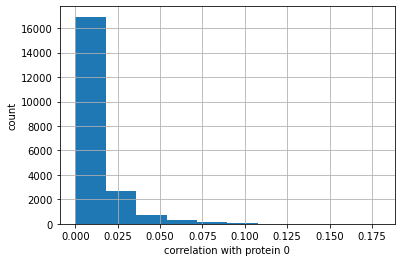

In [46]:
pd.Series(all_corrs[0]).apply(abs).sort_values().hist()
plt.xlabel('correlation with protein 0')
plt.ylabel('count')

In [56]:
X[selector[(i,j)]].shape

(7476, 159)

In [60]:
X.shape

(70988, 20856)

In [69]:
X_copy = X.copy()

In [82]:
(0.10999999940395355+0.11999999731779099+0.12999999523162842+0.12999999523162842+0.10999999940395355+0.11999999731779099)/6

0.11999999731779099

In [77]:
for (i,j) in selector.keys():
    Y = Y_copy.copy()
    Y = Y[selector[(i,j)],0].reshape(-1,1)
    X = X_copy[selector[(i,j)]][:,my_corrs]
    evaluate(i,j,'cite',save=False,loss='mse')

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 0.10999999940395355
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 1 -----------
Mean squared error = 0.11999999731779099
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 2 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 3 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 4 -----------
Mean squared error = 0.10999999940395355
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 5 -----------
Mean squared error = 0.11999999731779099
Correlation = nan
Mean corr = nan


KeyboardInterrupt: 

In [81]:
(0.14000000059604645+0.12999999523162842+0.12999999523162842+0.17000000178813934+0.11999999731779099+0.11999999731779099)/6

0.13499999791383743

In [80]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()
for (i,j) in selector.keys():
    Y = Y_copy.copy()
    X = X_copy.copy()
    Y = Y[selector[(i,j)],0].reshape(-1,1)
    X = X[selector[(i,j)]]
    evaluate(i,j,'cite',save=False,loss='mse')

39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 0 -----------
Mean squared error = 0.14000000059604645
Correlation = nan
39/39 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 1 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 2 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
39/39 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 3 -----------
Mean squared error = 0.17000000178813934
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 4 -----------
Mean squared error = 0.11999999731779099
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 5 -----------
Mean squared error = 0.11999999731779099
Correlation = nan
Mean corr = nan
32/32 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 0 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
32/32 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 1 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
32/32 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 2 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
32/32 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 3 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
32/32 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 4 -----------
Mean squared error = 0.10999999940395355
Correlation = nan
32/32 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 5 -----------
Mean squared error = 0.12999999523162842
Correlation = nan
Mean corr = nan
44/44 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 0 -----------
Mean squared error = 0.10999999940395355
Correlation = nan
44/44 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 1 -----------
Mean squared error = 0.10000000149011612
Correlation = nan
44/44 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 2 -----------
Mean squared error = 0.10000000149011612
Correlation = nan
44/44 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 3 -----------
Mean squared error = 0.11999999731779099
Correlation = nan


KeyboardInterrupt: 